<a href="https://colab.research.google.com/github/JuanM-GG/Biologia-de-sistemas/blob/main/sensibilidad_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Título: Análisis de sensibilidad con R 

Nombre: Biología de sistemas

Fecha: 9 de diciembre del 2020

instalar librerías 

In [1]:
install.packages("deSolve")
install.packages("FME")
install.packages("rootSolve")
install.packages("sensitivity")
install.packages("checkmate")
install.packages("ODEnetwork")
install.packages("ODEsensitivity")
install.packages("vioplot")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rootSolve’, ‘coda’, ‘minpack.lm’, ‘minqa’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numbers’, ‘RcppArmadillo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘sm’, ‘zoo’




In [2]:
library(deSolve)
library(FME)
library(rootSolve)
library(sensitivity)
library(checkmate)
library(ODEnetwork)
library(ODEsensitivity)
library(vioplot)

Loading required package: rootSolve

Loading required package: coda

Registered S3 method overwritten by 'sensitivity':
  method    from 
  print.src dplyr

Loading required package: sm

Warning message:
“no DISPLAY variable so Tk is not available”
Package 'sm', version 2.2-5.6: type help(sm) for summary information

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




Modelo de Lotka-Volterra

In [3]:
LVmod <- function(time, state, parms) {
  with(as.list(c(parms, state)),{

    growth_prey <- r * P * (1 - P/K) 
    ingestion <- c * P * N
    mort_predator <- delta * N

    dP <- growth_prey - ingestion
    dN <- a * ingestion - mort_predator

    return(list(c(dP, dN)))
  })
}

Existen cinco parámetros en el modelo: 


1.   r, tasa de crecimiento de la presa (1/tiempo)
2.   K, capacidad de carga de la presa (presa)
3.   c, tasa de consumo de presas por el depredador (1/tiempo*depredador)
4.   a, coeficiente que mide la asimilación del consumo por parte del depredador (depredador/presa)
5.   delta, tasa de muerte del depredador

Estos cinco parámetros son considerados como las variables de entrada en el análisis de sensibilidad. Por lo tanto, analizaremos la sensibilidad de las poblaciones de presa y depredador con respecto a cambios en estos cinco parámetros


Los parámetros a ser considerados en el análisis de sensibilidad y sus límites inferior y superior son: 

In [4]:
LVpars <- c("r","K","c","a","delta")
LVbinf <- c(0.05,0.05,0.05,0.05,1)
LVbsup <- c(1.00,3.00,0.95,0.95,20)

Condiciones iniciales

In [5]:
s <- c(P = 1, N = 2)

Intervalo de tiempo de interés

In [6]:
LVtimes <- c(0.01, seq(1, 5, by = 0.1)) 

Análisis Sobol (aquí solo con n = 500, pero se recomienda n = 1000)

Cuidado: El siguiente código podría tomar mucho tiempo en ejecutarse

In [7]:
set.seed(59281)
LVres_sobol <- ODEsobol(mod = LVmod, 
                        pars = LVpars, 
                        state_init = s, 
                        times = LVtimes, 
                        n = 500, 
                        rfuncs = "runif",
                        rargs = paste0("min = ", LVbinf, 
                                        ", max = ", LVbsup),
                                        sobol_method = "Martinez",
                                        ode_method = "lsoda",
                                        parallel_evel = TRUE,
                                        parallel_eval_ncores = 2)

Warning message:
“Negative first order indices (< -0.05) for state variable(s) "P", "N" detected. Argument "n" might be too low. If using a higher value for "n" doesn't help, please check if the parameter distributions ("rfuncs") and their arguments ("rargs") generate valid parameter values.”
Warning message:
“Total indices > 1.05 for state variable(s) "N" detected. Argument "n" might be too low. If using a higher value for "n" doesn't help, please check if the parameter distributions ("rfuncs") and their arguments ("rargs") generate valid parameter values.”


Es una lista de la clase *ODEmorris* con un elemento por cada variable de estado (aquí, P y N). Esos elementos son matrices de *3 length(LVpars) + 1* renglones y *length(LVtimes)* columnas. El primer renglon contiene una copia de todos de todos los valores de tiempo. Los otros renglones contienen los 3 índices de sensibilidad Sobol para todos los parámetros en todos los 51 valores de tiempo. 

In [8]:
str(LVres_sobol, vec.len = 3, give.attr = FALSE)

List of 2
 $ P:List of 2
  ..$ S: num [1:6, 1:42] 0.01 0 0.678 0.136 ...
  ..$ T: num [1:6, 1:42] 0.01 0.119 0.874 0.197 ...
 $ N:List of 2
  ..$ S: num [1:6, 1:42] 0.01 0.023 0.023 0.0269 ...
  ..$ T: num [1:6, 1:42] 1.00e-02 8.52e-09 1.38e-07 7.32e-04 ...


Graficar resultados 

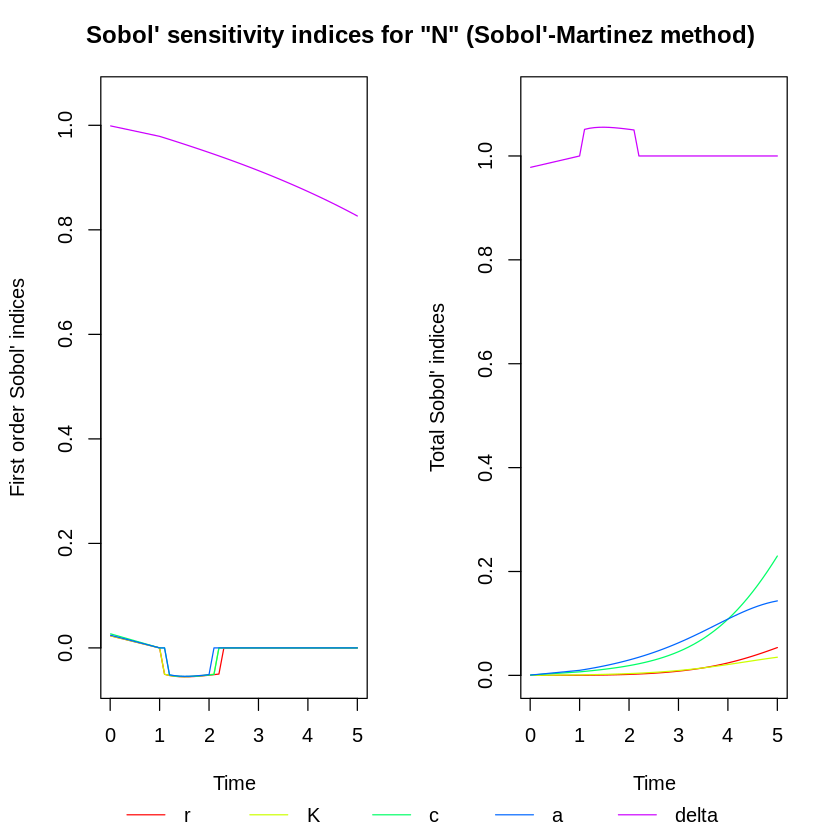

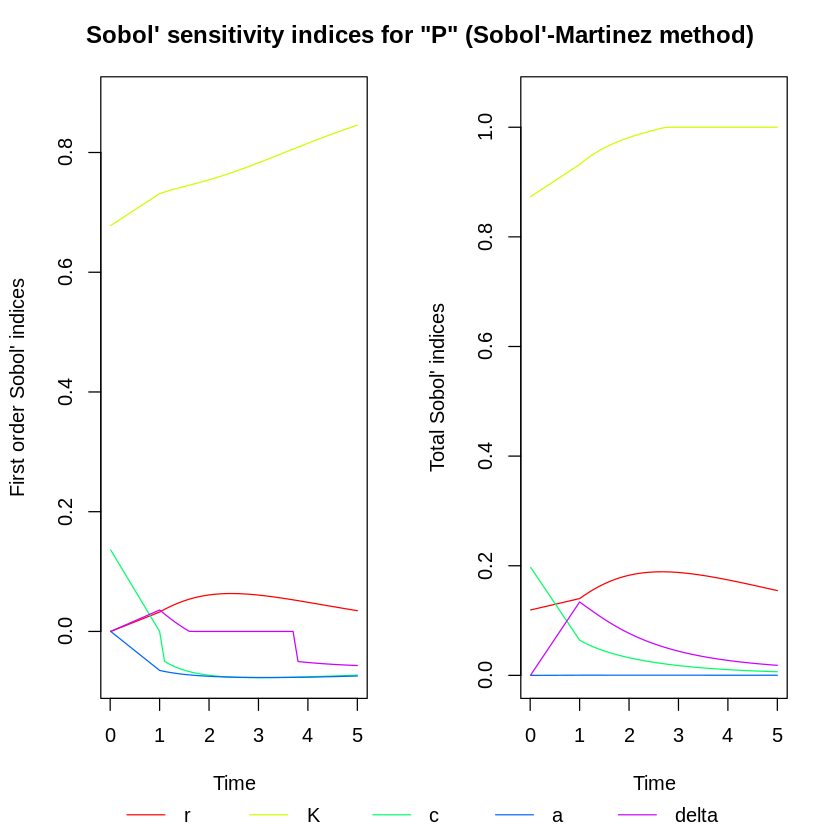

In [9]:
plot(LVres_sobol,  state_plot = "N")
plot(LVres_sobol,  state_plot = "P")

Ahora vamos a graficar la distribución de los indices por tiempo 

In [10]:
x1 <- LVres_sobol$P$S[2,]
x2 <- LVres_sobol$P$S[3,]
x3 <- LVres_sobol$P$S[4,]
x4 <- LVres_sobol$P$S[5,]
x5 <- LVres_sobol$P$S[6,]

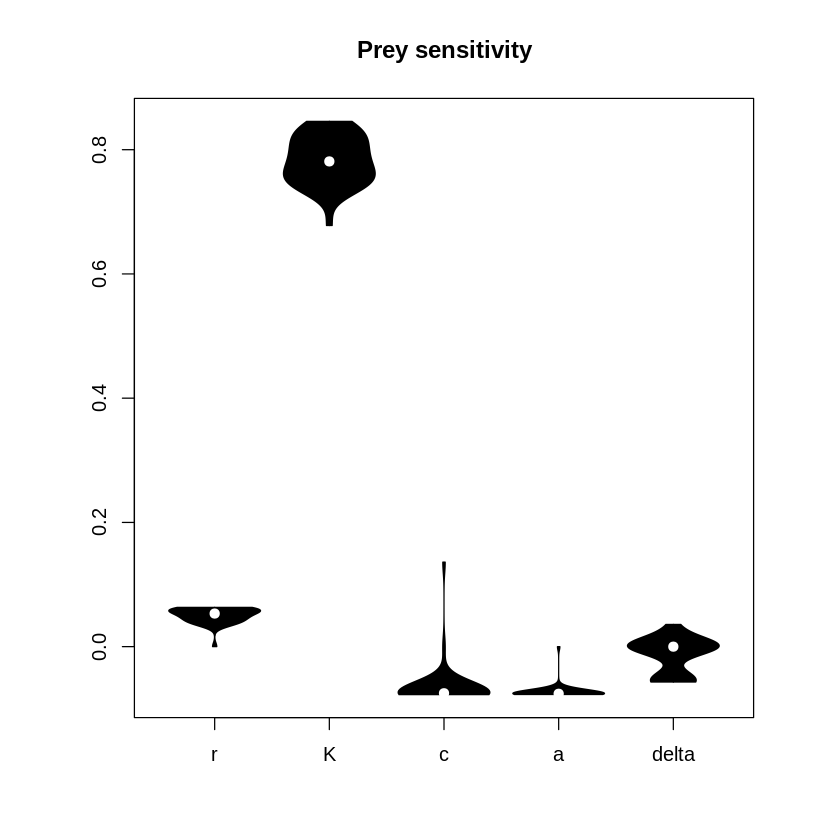

In [11]:
par(pty = "s")
vioplot(x1,x2,x3,x4,x5, names = LVpars, col = "black")
title("Prey sensitivity")

In [12]:

y1 <- LVres_sobol$N$S[2, ]
y2 <- LVres_sobol$N$S[3, ]
y3 <- LVres_sobol$N$S[4, ]
y4 <- LVres_sobol$N$S[5, ]
y5 <- LVres_sobol$N$S[6, ]

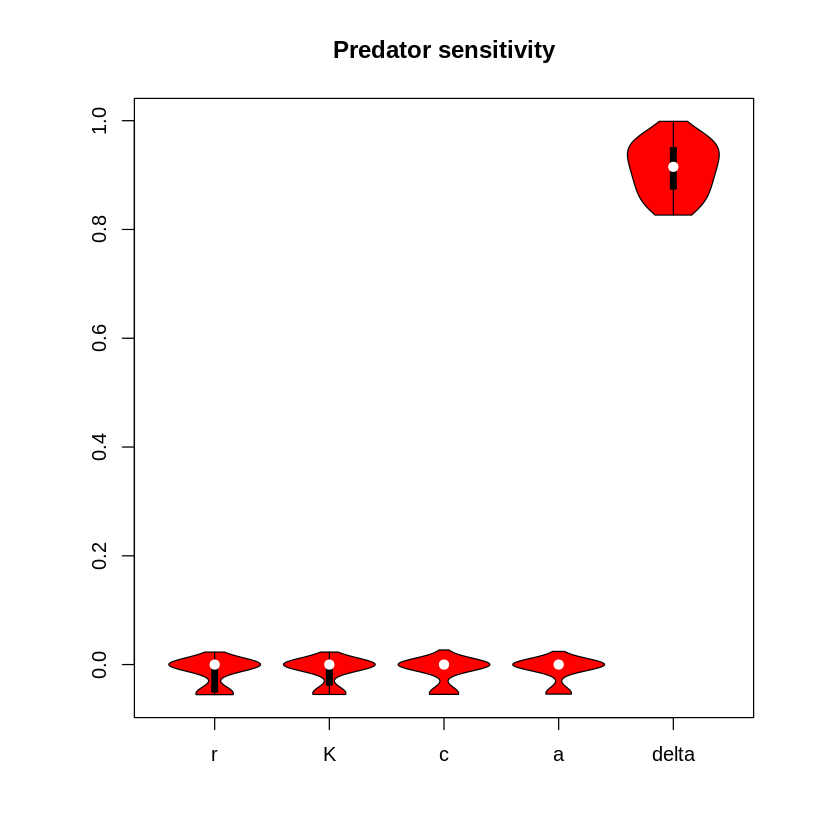

In [13]:
par(pty="s") 
vioplot(y1, y2, y3,y4, y5, names=LVpars,  col="red")
title("Predator sensitivity")